## Load Dependancies

In [1]:
project_name = 'dhcp'
import os
#get current working directory
cwd = os.getcwd()
git_dir = cwd.split(project_name)[0] + project_name
import sys

#add git_dir to path
sys.path.append(git_dir)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dhcp_params as params
from scipy import stats

from sklearn.manifold import MDS
import pdb

import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import seaborn.objects as so
import pingouin as pg

In [2]:
atlas = 'wang'


#load atlast name and roi labels
atlas_info = params.load_atlas_info(atlas)
group_params = params.load_group_params('infant')

sub_info = group_params.sub_list
subs2analyze = sub_info[(sub_info[f'{atlas}_exclude'] != 1) & (sub_info[f'{atlas}_ts'] == 1)]
age_groups = ['infant', 'adult']

#color code rois by network
#inds 1-7 are EVC
#inds 8-11 are ventral
#inds 12-17 are lateral
#inds 18-25 are dorsal

#add networks to roi labels
#roi_labels['network'] = ['Occipital']*6 + ['Ventral']*5 + ['Lateral']*6 + ['Dorsal']*7

networks = ['Occipital', 'Ventral', 'Lateral', 'Dorsal']
network_colors = ['#fd0000', '#be00fd', '#1105d8', 'green']


#set network order
network_order = networks
comp_order = ['same','diff']

age_bins = [26,33, 38,42,46]
age_groups = ['pre','early','term','post']

roi_labels = atlas_info.roi_labels

#expand roi labels to include hemis
all_rois = []
all_networks = []


all_rois = []
all_networks = []
for roi in roi_labels['label']:
    for hemi in params.hemis:
        all_rois.append(f'{hemi}_{roi}')
        all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])




## Load and process correlations

In [12]:
df_summary = pd.read_csv(f'{group_params.out_dir}/derivatives/{atlas}/infant_adult_{atlas}_correlations.csv')

#only include subs that are in subs2analyze
df_summary = df_summary[df_summary['sub'].isin(subs2analyze['participant_id'])]

#add age column
df_summary['age'] = (df_summary['scan_age'] - df_summary['birth_age']) * 7

#add age group column
df_summary['age_group'] = np.nan
for i in range(len(age_bins)-1):
    df_summary.loc[(df_summary['scan_age'] >= age_bins[i]) & (df_summary['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]

#load infant noise ceiliing
infant_noise = pd.read_csv(f'{group_params.out_dir}/derivatives/noise_ceiling/infant_{atlas}_split_half_reliability.csv')

#only include subs and ses that are in subs2analyze
infant_noise = infant_noise[infant_noise['ses'].isin(subs2analyze['ses'])]



#load adult noise ceilings
adult_noise_ceilings = pd.read_csv(f'{params.results_dir}/noise_ceilings/adult_{atlas}_fc_loo_noise_ceilings.csv')

df_noise_network = adult_noise_ceilings.groupby(['network1', 'roi_similarity'])['corr'].mean().reset_index()
#add standard error col
df_noise_network['std'] = adult_noise_ceilings.groupby(['network1', 'roi_similarity'])['corr'].std().reset_index()['corr']/np.sqrt(29)
#only keep same
df_noise_network = df_noise_network[df_noise_network['roi_similarity'] == 'same'] 


df_noise_roi = adult_noise_ceilings.groupby(['roi1', 'roi_similarity'])['corr'].mean().reset_index()
#add standard error col
df_noise_roi['std'] = adult_noise_ceilings.groupby(['roi1', 'roi_similarity'])['corr'].std().reset_index()['corr']/np.sqrt(29)
df_noise_roi = df_noise_roi[df_noise_roi['roi_similarity'] =='same']



#### Analyze subs scanned on day 1

In [13]:
#extract only subs with age <= 1
curr_df = df_summary[(df_summary['age'] <= 1) & (df_summary['age_group'] == 'term') | (df_summary['age'] <= 1) & (df_summary['age_group'] == 'post')]
#curr_df = df_summary[(df_summary['age'] <= 1)]

#groups at network level
df_network_summary = curr_df.groupby(['sub','ses', 'birth_age', 'scan_age','age','infant_network', 'roi_similarity','network_similarity'])['corr'].mean().reset_index()

#groups at roi level
df_roi_summary = curr_df.groupby(['sub','ses', 'birth_age', 'scan_age','age','infant_roi','adult_roi','adult_network', 'roi_similarity'])['corr'].mean().reset_index()

#extact only subs with age <= 1
#df_network_summary = df_network_summary[df_network_summary['age'] <= 1]
#df_roi_summary = df_roi_summary[df_roi_summary['age'] <= 1]

#group roi summary by roi
df_roi_summary = df_roi_summary.groupby(['infant_roi','adult_roi','adult_network', 'roi_similarity'])['corr'].mean().reset_index()



#### Plot Network corrs

infant_network  network_similarity
Occipital       same                  0.558378
                diff                  0.104659
Name: corr, dtype: float64
infant_network  network_similarity
Ventral         same                  0.369485
                diff                 -0.000557
Name: corr, dtype: float64
infant_network  network_similarity
Lateral         same                  0.374018
                diff                  0.114579
Name: corr, dtype: float64
infant_network  network_similarity
Dorsal          same                  0.519217
                diff                 -0.107469
Name: corr, dtype: float64


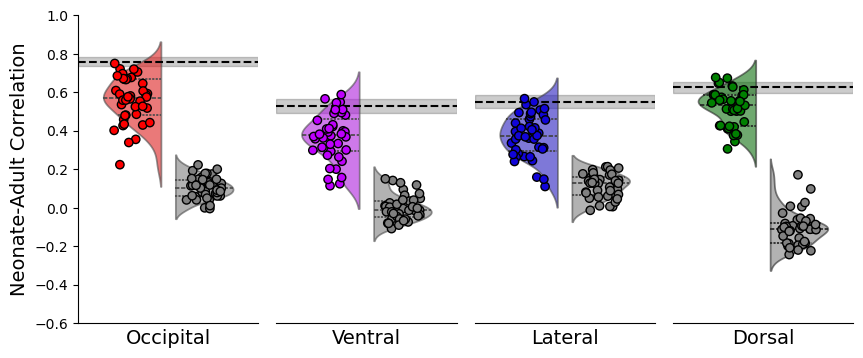

In [14]:
'''plot sub data at network level'''


#remove same region comparisons from df_summary_grouped and df_noise_grouped


#set network order
network_order = ['Occipital', 'Ventral', 'Lateral', 'Dorsal']
comp_order = ['same','diff']
#comp_order = ['Same\nRegion','Same\nNetwork','Different\nNetwork']


#set network order as categorical and level order
df_network_summary['network_similarity'] = pd.Categorical(df_network_summary['network_similarity'], categories=comp_order, ordered=True)
#df_summary_grouped['infant_network'] = pd.Categorical(df_summary_grouped['infant_network'], categories=network_order, ordered=True)


#create list of 12 gray colors
network_colors = [['#fd0000','gray'], ['#be00fd', 'gray'], ['#1105d8', 'gray'], ['green', 'gray']]

#loop through networks and create subplot for each
#set subplot size
fig,ax = plt.subplots(1,4,figsize=(10,4),sharey=False)
for i in range(0,len(network_order)):
    #print(network_order[i])
    curr_data = df_network_summary[(df_network_summary['infant_network']==network_order[i]) & (df_network_summary['roi_similarity'] == 'same') | (df_network_summary['infant_network']==network_order[i]) & (df_network_summary['network_similarity'] == 'diff')]
    
    print(curr_data.groupby(['infant_network','network_similarity'])['corr'].mean())
    
    #add horizontal line at noise ceiling
    ax[i].axhline(y=df_noise_network.loc[df_noise_network['network1']==network_order[i],'corr'].values[0], color = 'k', linestyle = '--')
    #add opaque rectangle behind noise ceiling with width of the standard deviation
    ax[i].axhspan(df_noise_network.loc[df_noise_network['network1']==network_order[i],'corr'].values[0]-df_noise_network.loc[df_noise_network['network1']==network_order[i],'std'].values[0],
                  df_noise_network.loc[df_noise_network['network1']==network_order[i],'corr'].values[0]+df_noise_network.loc[df_noise_network['network1']==network_order[i],'std'].values[0],
                  alpha=0.2, color='k')
        
    #add horizontal line at mean
    #ax[i].axhline(y=curr_data[curr_data['roi_similarity']=='same']['corr'].mean(), color = 'r', linestyle = '--')
    
    #plot summary_df
    sns.violinplot(data=curr_data, x= 'infant_network', y= 'corr', hue='network_similarity',
                   split = True,gap = .2, alpha = .6, inner = 'quart', palette = network_colors[i], ax = ax[i])

    #set alpha for all artists
    #for artist in ax[i].artists:
    #    artist.set_alpha(.5)

    sns.stripplot(data = curr_data,  x= 'infant_network', y= 'corr', hue = 'network_similarity', 
                  dodge=True,edgecolor = 'black', alpha = 1, linewidth=1,jitter = .2, size = 6,
                    palette = network_colors[i], ax = ax[i])




    
    #increase font size of x and y ticks
    #plt.xticks(fontsize = 10)
    #plt.yticks(fontsize = 10)

    #set y limits
    ax[i].set_ylim([-.6,1])

    #add y label
    if i == 0:

        ax[i].set_ylabel('Neonate-Adult Correlation', fontsize = 14)
        #make axes black
        ax[i].spines['left'].set_color('k')
        



    else:
        
        #remove y label
        ax[i].set_ylabel('')
        #remove y ticks
        ax[i].set_yticks([])
        #remove y tick labels
        ax[i].set_yticklabels([])
        #remove y axis line
        ax[i].spines['left'].set_visible(False)

    #remove x ticks and labels
    ax[i].set_xticks([])
    ax[i].set_xticklabels([])
    
    #add network as xlabel for each subplort
    ax[i].set_xlabel(network_order[i], fontsize = 14)
    #add x label
    #plt.xlabel('Network', fontsize = 20)

    #make axes black
    ax[i].spines['bottom'].set_color('k')
    

    #remove top and right axes
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

    #remove legend
    ax[i].get_legend().remove()

    #print(curr_data.groupby(['infant_network','comparison'])['corr'].mean().reset_index())

plt.subplots_adjust(wspace=.1, hspace=0)

#save 
plt.savefig(f'{git_dir}/figures/infant_adult_seed_correlation.png', bbox_inches='tight', dpi=300)

#### Plot ROI corrs

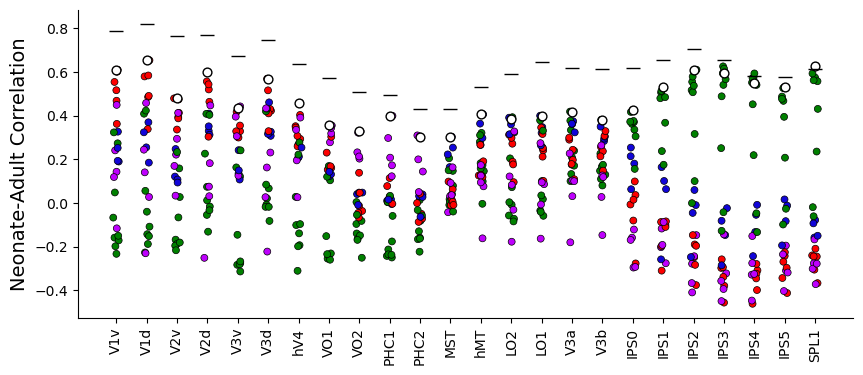

In [15]:
'''Plot data at roi level'''
network_colors = ['#fd0000', '#be00fd', '#1105d8', 'green']
network_order= ['Occipital','Ventral','Lateral','Dorsal']

#set network order as categorical and level order
df_roi_summary['infant_roi'] = pd.Categorical(df_roi_summary['infant_roi'], categories=roi_labels['label'], ordered=True)
df_roi_summary['adult_network'] = pd.Categorical(df_roi_summary['adult_network'], categories=network_order, ordered=True)

df_roi_same = df_roi_summary[df_roi_summary['infant_roi']==df_roi_summary['adult_roi']]



sns.scatterplot(data = df_roi_same, x = 'infant_roi', y = 'corr', color = 'white', linewidth = 1, s = 40, edgecolor = 'k', legend = False,zorder = 10)
sns.stripplot(data = df_roi_summary, x = 'infant_roi', y = 'corr', hue = 'adult_network', palette = network_colors, linewidth = .5, s = 5, edgecolor = 'k',jitter=.1,zorder = 0)


#create scatter plot of noise ceiling
sns.scatterplot(data = df_noise_roi, x = 'roi1', y = 'corr', color = 'black', linewidth = 1, s = 100, marker="_", edgecolor = 'k', legend = False, zorder =15)

#remove legend
plt.legend([],[], frameon=False)

#change plot size
plt.gcf().set_size_inches(10,4)

#angle x axis labels
plt.xticks(rotation=90)

#remove top and right spines
sns.despine()

#add y axis label
plt.ylabel('Neonate-Adult Correlation', fontsize = 14)

#remove X axis label
plt.xlabel('')

#save
plt.savefig(f'{git_dir}/figures/infant_adult_seed_correlation_roi.png', bbox_inches='tight', dpi=300)

#### Create network bar graphs

In [16]:
def plot_network_corr(summary_df,noise_ceiling_df = None, file_name = None):

    #capitalize network names
    #summary_df.columns = [net.capitalize() for net in summary_df.columns]

    #Replace EVC column with early vision
    #summary_df = summary_df.rename(columns = {'Evc':'EVC'})

    summary_df['infant_network'] = pd.Categorical(summary_df['infant_network'], categories=network_order, ordered=True)

    #plot summary_df
    ax = sns.barplot(data = summary_df, x = 'infant_network',y='corr', errorbar=('ci',95), edgecolor = 'k',palette = network_colors,
                    alpha = .8)
    sns.stripplot(data = summary_df,  x = 'infant_network',y='corr', edgecolor = 'black', alpha = .5, linewidth=1,jitter = .2, size = 6,
                palette = network_colors, ax = ax)

    #add noise ceilings as dot above each bar
    if noise_ceiling_df is not None:
        for i, net in enumerate(networks):
            #add noise ceiling
            #plt.plot(i, noise_ceiling_df[noise_ceiling_df['network1'] == net]['corr'].mean(), '_', color = 'gray', markersize = 15, markeredgecolor = 'k')

            #add noise ceiling as line
            plt.plot([i-.4, i+.4], [noise_ceiling_df[noise_ceiling_df['network1'] == net]['corr'].mean(), noise_ceiling_df[noise_ceiling_df['network1'] == net]['corr'].mean()], color = 'black', linestyle = '--')

            #add shaded region for standard error
            plt.fill_between([i-.4, i+.4], noise_ceiling_df[noise_ceiling_df['network1'] == net]['corr'].mean() - noise_ceiling_df[noise_ceiling_df['network1'] == net]['std'].mean(),
                            noise_ceiling_df[noise_ceiling_df['network1'] == net]['corr'].mean() + noise_ceiling_df[noise_ceiling_df['network1'] == net]['std'].mean(), color = 'gray', alpha = .2)

    #increase font size of x and y ticks
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)

    #add y label
    plt.ylabel('Neonate-Adult Correlation', fontsize = 20)

    #add x label
    #plt.xlabel('Network', fontsize = 20)

    #make axes black
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')

    #remove top and right axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #make graph smaller
    plt.gcf().set_size_inches(5,8)

    #remove x axis label
    plt.xlabel('')

    if file_name is not None:
       
        #save plot
        plt.savefig(f'{git_dir}/figures/maturity/{file_name}.png', bbox_inches = 'tight', dpi = 300)


    plt.show()
    plt.pause(.001)


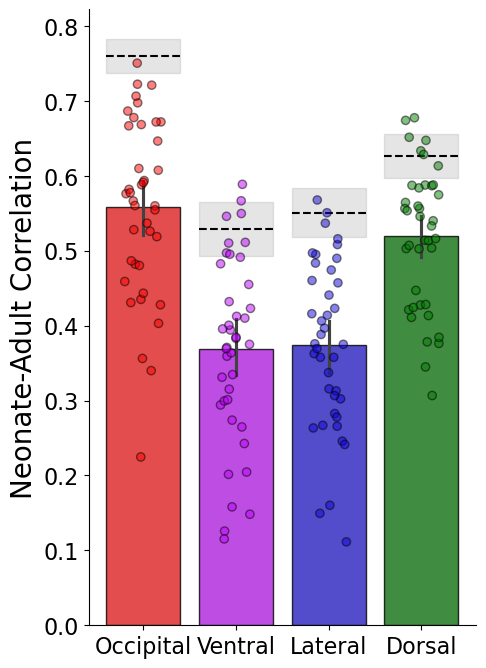

In [17]:
df_same_only = df_network_summary[df_network_summary['roi_similarity'] == 'same']

plot_network_corr(df_same_only,df_noise_network, 'neonate_adult_network_corr')

#MAKE NOISE CORECTED BARS

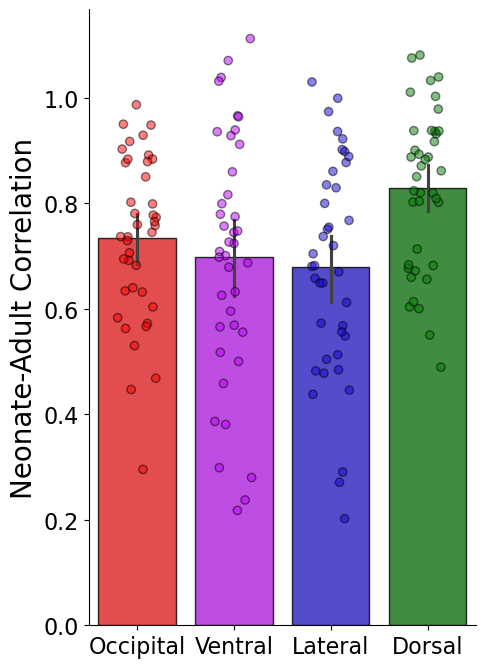

In [18]:
'''create noise ceiling normalized bars'''
df_noise_corrected = df_same_only.copy()

#add noise ceiling to df_noise_corrected
df_noise_corrected['noise_ceiling'] = np.nan
for i, net in enumerate(networks):
    df_noise_corrected.loc[df_noise_corrected['infant_network'] == net, 'noise_ceiling'] = df_noise_network.loc[df_noise_network['network1'] == net, 'corr'].values[0]

#normalize correlation by noise ceiling
df_noise_corrected['corr'] = df_noise_corrected['corr']/ df_noise_corrected['noise_ceiling']

plot_network_corr(df_noise_corrected,None, file_name='neonate_adult_network_corr_normalized')

### Plot correlatiosn as a funciton of within- or between-network

In [10]:
#extract only subs with age <= 1
curr_df = df_summary[(df_summary['age'] <= 1) & (df_summary['age_group'] == 'term') | (df_summary['age'] <= 1) & (df_summary['age_group'] == 'post')]

#extract same network data
within_network = curr_df[curr_df['network_similarity'] == 'same']

#groups at network level
df_network_summary = curr_df.groupby(['sub','ses', 'birth_age', 'scan_age','age','infant_network', 'roi_similarity','network_similarity'])['corr'].mean().reset_index()

within_network = within_network.groupby(['sub','ses', 'birth_age', 'scan_age','age','infant_network'])['corr'].mean().reset_index()

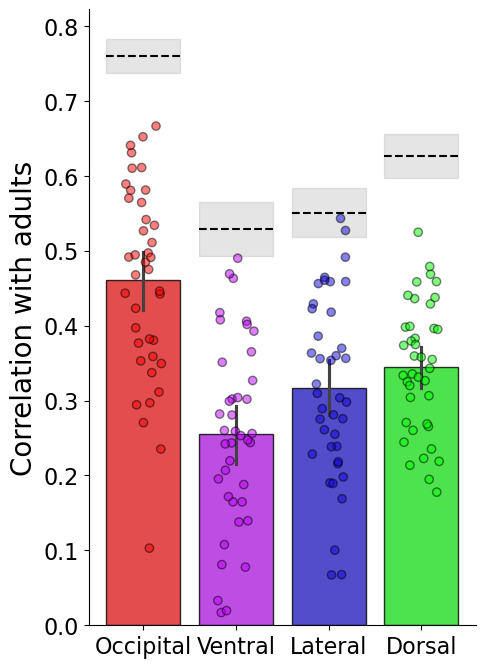

In [11]:
#plot within network correlations and noise ceiling
plot_network_corr(within_network,df_noise_network)

### Maturity as a function of Gestational Age

In [21]:
'''Non noise ceiling normalized data'''
df_summary = pd.read_csv(f'{group_params.out_dir}/derivatives/{atlas}/infant_adult_{atlas}_correlations.csv')

#only include subs that are in subs2analyze
df_summary = df_summary[df_summary['sub'].isin(subs2analyze['participant_id'])]

#add age column
df_summary['age'] = (df_summary['scan_age'] - df_summary['birth_age']) * 7

#add age group column
df_summary['age_group'] = np.nan
for i in range(len(age_bins)-1):
    df_summary.loc[(df_summary['scan_age'] >= age_bins[i]) & (df_summary['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]


#extract only network_similarity == same data
df_same = df_summary[df_summary['roi_similarity'] == 'same']

age_summary =df_same.groupby(['sub','ses', 'age_group','infant_network'])['corr'].mean().reset_index()

#set infant_network as categorical
age_summary['infant_network'] = pd.Categorical(age_summary['infant_network'], categories=network_order, ordered=True)

#set age group as categorical
age_summary['age_group'] = pd.Categorical(age_summary['age_group'], categories=age_groups, ordered=True)

#rename age groups
age_summary['age_group'] = age_summary['age_group'].replace({'pre':'Pre-Term', 'early':'Early-Term', 'term':'Term', 'post':'Post-Term'})



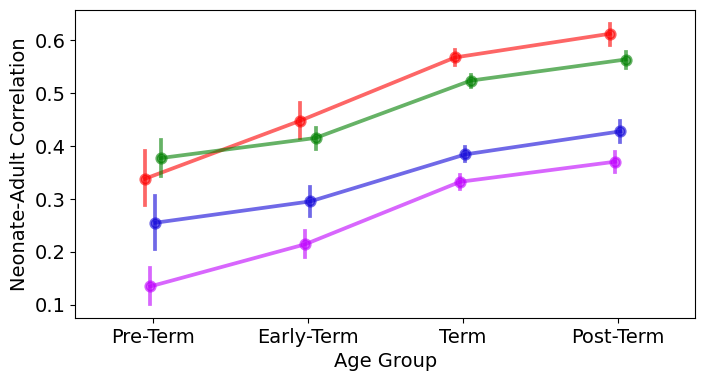

In [22]:
#plotsize
plt.figure(figsize=(8,4))
#plot age group data as line plot
sns.pointplot(data = age_summary, x = 'age_group', y = 'corr', hue = 'infant_network', palette = network_colors, ci = 95, dodge = True, alpha = .6)

#set x axis fontsize
plt.xticks(fontsize = 14)
#change y axis fontsize
plt.yticks(fontsize = 14)

#change x axist title
plt.xlabel('Age Group', fontsize = 14)

#change y axis title
plt.ylabel('Neonate-Adult Correlation', fontsize = 14)

#remove legend
plt.legend([],[], frameon=False)

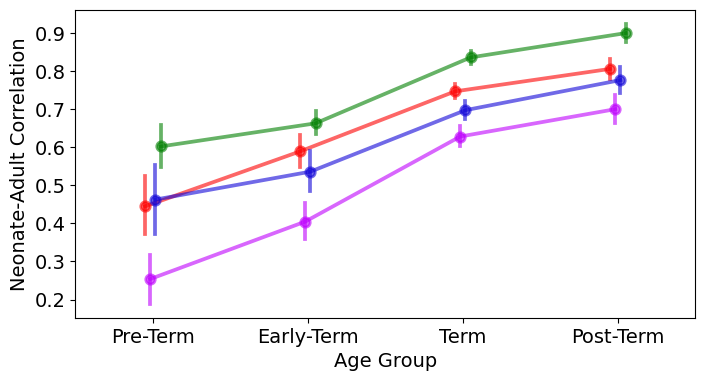

In [23]:
df_noise_corrected = df_same.copy()

#add noise ceiling to df_noise_corrected
df_noise_corrected['noise_ceiling'] = np.nan
for i, net in enumerate(networks):
    df_noise_corrected.loc[df_noise_corrected['infant_network'] == net, 'noise_ceiling'] = df_noise_network.loc[df_noise_network['network1'] == net, 'corr'].values[0]

#normalize correlation by noise ceiling
df_noise_corrected['corr'] = df_noise_corrected['corr']/ df_noise_corrected['noise_ceiling']


age_summary =df_noise_corrected.groupby(['sub','ses', 'age_group','infant_network'])['corr'].mean().reset_index()

#set infant_network as categorical
age_summary['infant_network'] = pd.Categorical(age_summary['infant_network'], categories=network_order, ordered=True)

#set age group as categorical
age_summary['age_group'] = pd.Categorical(age_summary['age_group'], categories=age_groups, ordered=True)

#rename age groups
age_summary['age_group'] = age_summary['age_group'].replace({'pre':'Pre-Term', 'early':'Early-Term', 'term':'Term', 'post':'Post-Term'})


#plotsize
plt.figure(figsize=(8,4))
#plot age group data as line plot
sns.pointplot(data = age_summary, x = 'age_group', y = 'corr', hue = 'infant_network', palette = network_colors, ci = 95, dodge = True, alpha = .6)

#set x axis fontsize
plt.xticks(fontsize = 14)
#change y axis fontsize
plt.yticks(fontsize = 14)

#change x axist title
plt.xlabel('Age Group', fontsize = 14)

#change y axis title
plt.ylabel('Neonate-Adult Correlation', fontsize = 14)

#remove legend
plt.legend([],[], frameon=False)


## Pulvinar Maturity -> cortical maturity

In [3]:
#compute bootstrap confidience intervals
def bootstrap_ci(data, target_cols,control= None, n_iter = 10, ci = 95):


    #unlist nested list of target cols
    all_targets = [item for sublist in target_cols for item in sublist]

    #initialize array to store bootstrapped means
    boot_corrs = np.zeros((n_iter, len(target_cols)))
    for i in range(n_iter):
        #sample with replacement
        boot_sample = data.sample(n = len(data), replace = True)
        #compute pairwise correlation
        all_corrs = pg.pairwise_corr(boot_sample, columns = all_targets, covar=control, method = 'pearson')

        n =0
        #extract correlations from target cols
        for target in target_cols:
            #add targets from corrs to corr_summary using concat
            corr = all_corrs[(all_corrs['X'] == target[0]) & (all_corrs['Y'] == target[1])]['r'].values[0]
            

            #add correlatinos to boot_corrs 
            boot_corrs[i,n] = corr

            n+=1
            

    #compute confidence intervals for each column
    ci_low = np.percentile(boot_corrs, (100-ci), axis = 0)
    ci_high = np.percentile(boot_corrs, 100-(100-ci), axis = 0)

    return ci_low, ci_high, boot_corrs


In [4]:
'''RUn pulvinar correlations on a subject by subject basis'''
#load pulvinar_dwi_correlation data
pulvinar_df = pd.read_csv(f'{git_dir}/results/roi_corrs/pulvinar_dwi_session_correlations_40wk.csv')

#only include subs in subs2analyze
pulvinar_df = pulvinar_df[pulvinar_df['sub'].isin(subs2analyze['participant_id'])]

#remove rows with missing data
pulvinar_df = pulvinar_df.dropna()




#fisher z transform cortex and pulvinar columns
pulvinar_df['t1_cortex_corr'] = np.arctanh(pulvinar_df['t1_cortex_corr'])
pulvinar_df['t2_cortex_corr'] = np.arctanh(pulvinar_df['t2_cortex_corr'])
pulvinar_df['t1_pulvinar_corr'] = np.arctanh(pulvinar_df['t1_pulvinar_corr'])
pulvinar_df['t2_pulvinar_corr'] = np.arctanh(pulvinar_df['t2_pulvinar_corr'])

sub_summary = pd.DataFrame(columns = ['sub','age_diff','t1_pulvinar-t2_cortex', 't1_cortex-t2_pulvinar'])
#loop through subs
for sub in pulvinar_df['sub'].unique():
    #check if sub has 24 values
    if len(pulvinar_df[pulvinar_df['sub'] == sub]) != 48:
        print(f'sub {sub} does not have 48 values')
        continue

    #extract subject data
    curr_sub = pulvinar_df[pulvinar_df['sub'] == sub]

    #extract age difference
    age_diff = curr_sub['age_diff'].values[0]   
    
    #correlation t1_pulvinar to t2_cortex
    t1p_t2c_corr = stats.pearsonr(curr_sub['t1_pulvinar_corr'], curr_sub['t2_cortex_corr'])

    #correlate t2_pulvinar to t1_cortex
    t2p_t1c_corr = stats.pearsonr(curr_sub['t2_pulvinar_corr'], curr_sub['t1_cortex_corr'])

    #add to sub summary
    sub_summary = pd.concat([sub_summary, pd.DataFrame({'sub': [sub], 'age_diff': [age_diff], 't1_pulvinar-t2_cortex': [t1p_t2c_corr[0]], 't1_cortex-t2_pulvinar': [t2p_t1c_corr[0]]})], ignore_index=True)


sub sub-CC00621XX11 does not have 48 values
sub sub-CC00661XX10 does not have 48 values
sub sub-CC00718XX17 does not have 48 values
sub sub-CC00867XX18 does not have 48 values
sub sub-CC01011XX05 does not have 48 values
sub sub-CC00694XX19 does not have 48 values
sub sub-CC00525XX14 does not have 48 values
sub sub-CC01218XX14 does not have 48 values


<Axes: xlabel='comparison', ylabel='corr'>

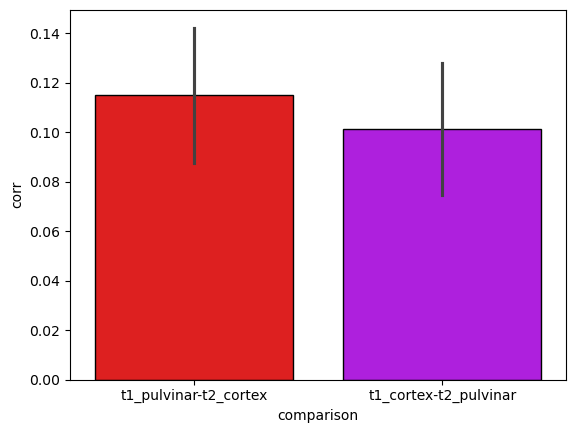

In [5]:
#melt sub_summary to long format
sub_summary_melt = sub_summary.melt(id_vars = ['sub','age_diff'], value_vars = ['t1_pulvinar-t2_cortex', 't1_cortex-t2_pulvinar'], var_name = 'comparison', value_name = 'corr')

#plot sub_summary_melt
sns.barplot(data = sub_summary_melt, x = 'comparison', y = 'corr', errorbar=('se'), edgecolor = 'k', palette = ['#fd0000','#be00fd'])

In [6]:
#load pulvinar_dwi_correlation data
pulvinar_df = pd.read_csv(f'{git_dir}/results/roi_corrs/pulvinar_dwi_session_correlations_40wk.csv')

#remove rows with missing data
pulvinar_df = pulvinar_df.dropna()

#fisher z transform cortex and pulvinar columns
pulvinar_df['t1_cortex_corr'] = np.arctanh(pulvinar_df['t1_cortex_corr'])
pulvinar_df['t2_cortex_corr'] = np.arctanh(pulvinar_df['t2_cortex_corr'])
pulvinar_df['t1_pulvinar_corr'] = np.arctanh(pulvinar_df['t1_pulvinar_corr'])
pulvinar_df['t2_pulvinar_corr'] = np.arctanh(pulvinar_df['t2_pulvinar_corr'])


#create a new dataframe with the correlation between cortex and pulvinar
corr_summary = pd.DataFrame(columns=['predictor','outcome','corr','CI-low','CI-high'])

#do pairwise correlations between cortex and pulvinar columns
#corr_cols = pulvinar_df[['t1_cortex_corr','t2_cortex_corr','t1_pulvinar_corr','t2_pulvinar_corr']]

#compute partial correlation between t1_cortex and t2_pulvinar, controlling for age_diff
all_corrs = pg.pairwise_corr(data = pulvinar_df, columns = ['t1_cortex_corr','t2_cortex_corr','t1_pulvinar_corr','t2_pulvinar_corr'], method = 'spearman')

#corrs to extract

targets = [['t1_cortex_corr','t2_pulvinar_corr'],['t2_cortex_corr','t1_pulvinar_corr']]
for target in targets:
    #add targets from corrs to corr_summary using concat
    curr_corr = all_corrs[(all_corrs['X'] == target[0]) & (all_corrs['Y'] == target[1])]
    corr_summary = pd.concat([corr_summary, pd.DataFrame({'predictor':[target[0]],'outcome':[target[1]],'corr':[curr_corr['r'].values[0]]})])

#compute CI for each correlation
ci_low, ci_high, boot_corrs = bootstrap_ci(pulvinar_df,targets, None, n_iter = 10000, ci = 95)

#add CI to corr_summary
corr_summary['CI-low'] = ci_low
corr_summary['CI-high'] = ci_high

#corr_summary = pd.concat([corr_summary, pd.DataFrame({'predictor':['t1_cortex_corr'],'outcome':['t2_pulvinar_corr'],'corr':[corrs.loc[0,'r']],'CI-low':[corrs.loc[0,'CI95%'][0]],'CI-high':[corrs.loc[0,'CI95%'][1]]})])


#corr1 = pg.partial_corr(data = pulvinar_df, x = 't1_cortex_corr', y = 't2_pulvinar_corr', covar = 'age_diff', method = 'pearson')
#corr2 = pg.partial_corr(data = pulvinar_df, x = 't2_cortex_corr', y = 't1_pulvinar_corr', covar = 'age_diff', method = 'pearson')


#add to corr_summary using concat
#corr_summary = pd.concat([corr_summary, pd.DataFrame({'predictor':['t1_cortex_corr'],'outcome':['t2_pulvinar_corr'],'corr':[corr1['r'].values[0]],'CI-low':[corr1['CI95%'][0][0]],'CI-high':[corr1['CI95%'][0][1]]})])
#corr_summary = pd.concat([corr_summary, pd.DataFrame({'predictor':['t2_cortex_corr'],'outcome':['t1_pulvinar_corr'],'corr':[corr2['r'].values[0]],'CI-low':[corr2['CI95%'][0][0]],'CI-high':[corr2['CI95%'][0][1]]})])


#save corr_summary
corr_summary.to_csv(f'{git_dir}/results/roi_corrs/pulvinar_dwi_correlation_summary.csv', index = False)



'''
#melt correlation matrix into a table
corrs = corrs.reset_index()
corrs = pd.melt(corrs, id_vars = 'index')
#remove rows where the predictor and outcome are the same
corr_summary = corrs[corrs['index'] != corrs['variable']]
#remove rows with duplicates in the value column
corr_summary = corr_summary.drop_duplicates(subset = 'value')

#rename columns
corr_summary.columns = ['predictor','outcome','corr']

#compute confidence intervals
ci_low, ci_high = bootstrap_ci(corr_cols,10000)
corr_summary['CI-low'] = ci_low
corr_summary['CI-high'] = ci_high

'''

"\n#melt correlation matrix into a table\ncorrs = corrs.reset_index()\ncorrs = pd.melt(corrs, id_vars = 'index')\n#remove rows where the predictor and outcome are the same\ncorr_summary = corrs[corrs['index'] != corrs['variable']]\n#remove rows with duplicates in the value column\ncorr_summary = corr_summary.drop_duplicates(subset = 'value')\n\n#rename columns\ncorr_summary.columns = ['predictor','outcome','corr']\n\n#compute confidence intervals\nci_low, ci_high = bootstrap_ci(corr_cols,10000)\ncorr_summary['CI-low'] = ci_low\ncorr_summary['CI-high'] = ci_high\n\n"

([0, 1],
 [Text(0, 0, 't1_cortex_corr - t2_pulvinar_corr'),
  Text(1, 0, 't2_cortex_corr - t1_pulvinar_corr')])

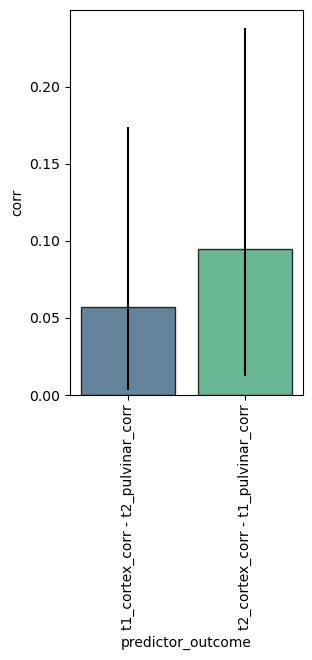

In [7]:
#load coor_summary
corr_summary = pd.read_csv(f'{git_dir}/results/roi_corrs/pulvinar_dwi_correlation_summary.csv')

#create new column combining predictor and outcome
corr_summary['predictor_outcome'] = corr_summary['predictor'] + ' - ' + corr_summary['outcome']

#onl keep

#create bar graph of correlations with CIs are error bars
fig, ax = plt.subplots(figsize = (3,5))
sns.barplot(data = corr_summary, x = 'predictor_outcome', y = 'corr', edgecolor = 'k', alpha = .8, palette = 'viridis')
plt.errorbar(x = range(len(corr_summary)), y = corr_summary['corr'], yerr = [corr_summary['CI-low'], corr_summary['CI-high']],
             fmt = 'none', ecolor = 'k', capsize = 0, capthick = 2)

#orient x axis labels
plt.xticks(rotation = 90)

0.13160000000000005


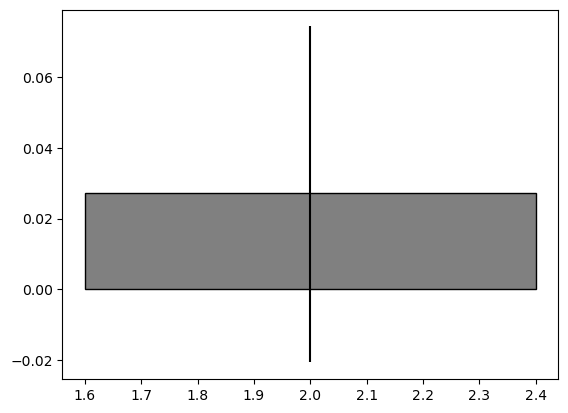

In [8]:
#convert boot_corrs into a dataframe
boot_corrs_df = pd.DataFrame(boot_corrs, columns = ['T1-Cortex - T2-Pulvinar','T2-Cortex - T1-Pulvinar'])

#create difference column
boot_corrs_df['Difference'] =  boot_corrs_df['T2-Cortex - T1-Pulvinar'] - boot_corrs_df['T1-Cortex - T2-Pulvinar']

#compute confidence intervals for difference
ci_low, ci_high = np.percentile(boot_corrs_df['Difference'], (2.5,97.5))

#plot difference column as bar
plt.bar(2, boot_corrs_df['Difference'].mean(), yerr = [[boot_corrs_df['Difference'].mean() - ci_low],[ci_high - boot_corrs_df['Difference'].mean()]], color = 'gray', edgecolor = 'k')

#compute p value
p = np.sum(boot_corrs_df['Difference'] > 0)/len(boot_corrs_df)
print(1-p)


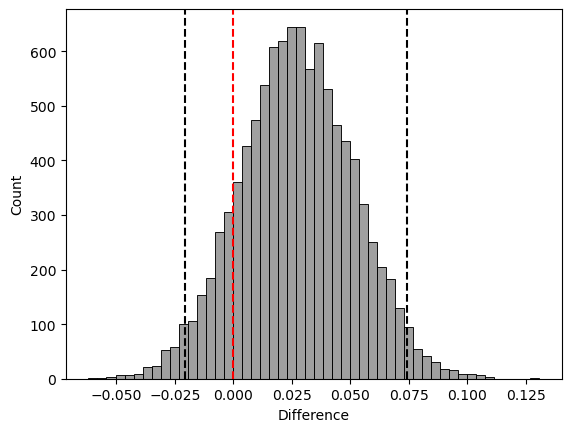

In [9]:
#plot differences as a distribution
plt.figure()
sns.histplot(boot_corrs_df['Difference'], bins = 50, color = 'gray')
plt.axvline(x = ci_low, color = 'k', linestyle = '--')
plt.axvline(x = ci_high, color = 'k', linestyle = '--')

#add reference line at 0
plt.axvline(x = 0, color = 'r', linestyle = '--')



In [10]:
#loop through each ROI and compute the correlation between the cortex and pulvinar
roi_summary = pd.DataFrame(columns = ['roi','Pulvinar_T1->Cortex_T2','Cortex_T1->Pulvinar_T2'])
targets = [['t1_cortex_corr','t2_pulvinar_corr'],['t2_cortex_corr','t1_pulvinar_corr']]

for roi in pulvinar_df['roi'].unique():
    curr_df = pulvinar_df[pulvinar_df['roi'] == roi]

    all_corrs = pg.pairwise_corr(data = curr_df, columns = ['t1_cortex_corr','t2_cortex_corr','t1_pulvinar_corr','t2_pulvinar_corr'], covar = 'age_diff', method = 'pearson')

    t1_p_t2_c = pg.pairwise_corr(data = curr_df, columns = ['t1_pulvinar_corr','t2_cortex_corr'], covar = 'age_diff', method = 'pearson')['r'].values[0]
    t1_c_t2_p = pg.pairwise_corr(data = curr_df, columns = ['t1_cortex_corr','t2_pulvinar_corr'], covar = 'age_diff', method = 'pearson')['r'].values[0]


      
    #add to roi_summary using pd.concat
    roi_summary = pd.concat([roi_summary, pd.DataFrame({'roi':[roi],'Pulvinar_T1->Cortex_T2':[t1_p_t2_c],'Cortex_T1->Pulvinar_T2':[t1_c_t2_p]})])


#melt
roi_summary = pd.melt(roi_summary, id_vars = 'roi')
#rename roi variable to predictor_outcome
roi_summary = roi_summary.rename(columns = {'variable':'predictor_outcome','value':'corr'})



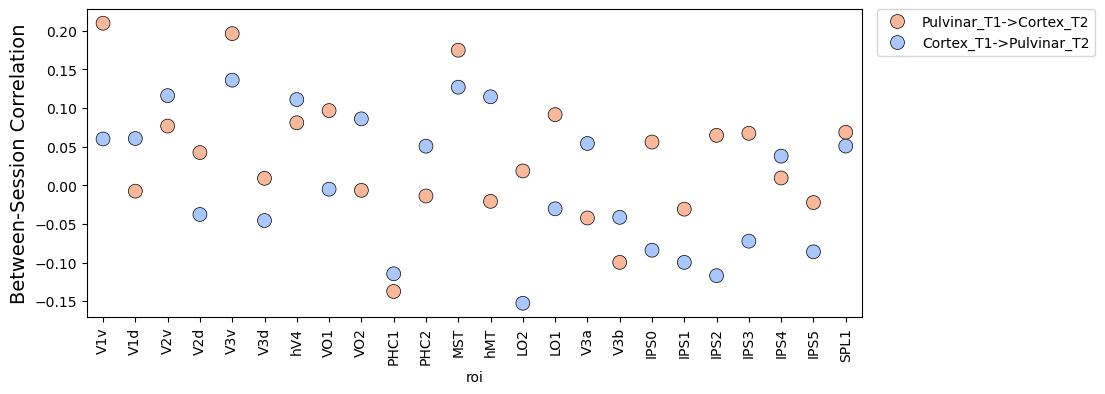

In [11]:
#plot as point plot
fig, ax = plt.subplots()
sns.stripplot(data = roi_summary, x='roi', y= 'corr', hue = 'predictor_outcome', palette = 'coolwarm_r',linewidth = .5, s = 10, edgecolor = 'k',jitter=0,zorder = 0)
plt.xticks(rotation = 90)

#put legend outside of plot
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

#update y axis
plt.ylabel('Between-Session Correlation', fontsize = 14)

plt.gcf().set_size_inches(10,4)

In [27]:
ci = 95
n_iter = 10
data = corr_cols

n_cols= int((data.shape[1] * (data.shape[1] - 1)) / 2)

#initialize array to store bootstrapped means
boot_means = np.zeros((n_iter, n_cols))
for i in range(n_iter):
    #sample with replacement
    boot_sample = data.sample(n = len(data), replace = True)
    #compute pairwise correlation
    corrs = boot_sample.corr()

    corrs = corrs.reset_index()
    corrs = pd.melt(corrs, id_vars = 'index')
    #remove rows where the predictor and outcome are the same
    corr_summary = corrs[corrs['index'] != corrs['variable']]
    #remove rows with duplicates in the value column
    corr_summary = corr_summary.drop_duplicates(subset = 'value')

    #add correlatinos to boot_means
    boot_means[i,:] = corr_summary['value'].values.T


#compute confidence intervals for each column
ci_low = np.percentile(boot_means, (100-ci)/2, axis = 0)
ci_high = np.percentile(boot_means, 100-(100-ci)/2, axis = 0)


In [19]:
#compute confidence intervals
boot_means, ci_low, ci_high = bootstrap_ci(corr_cols, n_iter = 10)

TypeError: Cannot interpret '4' as a data type

In [ ]:

#melt correlation matrix into a table
corrs = corrs.reset_index()
corrs = pd.melt(corrs, id_vars = 'index')
#remove rows where the predictor and outcome are the same
corr_summary = corrs[corrs['index'] != corrs['variable']]
#remove rows with duplicates in the value column
corr_summary = corr_summary.drop_duplicates(subset = 'value')

#compute confidence intervals



In [ ]:





#add t1 cortex and t1 pulvinar
corr_summary.loc[0] = ['t1_cortex','t1_pulvinar',pulvinar_df['t1_cortex_corr'].corr(pulvinar_df['t1_pulvinar_corr']),
                        *stats.pearsonr(pulvinar_df['t1_cortex_corr'],pulvinar_df['t1_pulvinar_corr'])]
#add t2 cortex and t2 pulvinar
corr_summary.loc[1] = ['t2_cortex','t2_pulvinar',pulvinar_df['t2_cortex_corr'].corr(pulvinar_df['t2_pulvinar_corr']),
                        *stats.pearsonr(pulvinar_df['t2_cortex_corr'],pulvinar_df['t2_pulvinar_corr'])]

#add t1 cortex and t2 pulvinar
corr_summary.loc[2] = ['t1_cortex','t2_pulvinar',pulvinar_df['t1_cortex_corr'].corr(pulvinar_df['t2_pulvinar_corr']),
                        *stats.pearsonr(pulvinar_df['t1_cortex_corr'],pulvinar_df['t2_pulvinar_corr'])]

#add t1 pulvinar and t2 cortex
corr_summary.loc[3] = ['t1_pulvinar','t2_cortex',pulvinar_df['t1_pulvinar_corr'].corr(pulvinar_df['t2_cortex_corr']),
                        *stats.pearsonr(pulvinar_df['t1_pulvinar_corr'],pulvinar_df['t2_cortex_corr'])]

#create new column of with predictor and outcome combined
corr_summary['predictor_outcome'] = corr_summary['predictor'] + '_' + corr_summary['outcome']


([0, 1, 2, 3],
 [Text(0, 0, 't1_cortex_t1_pulvinar'),
  Text(1, 0, 't2_cortex_t2_pulvinar'),
  Text(2, 0, 't1_cortex_t2_pulvinar'),
  Text(3, 0, 't1_pulvinar_t2_cortex')])

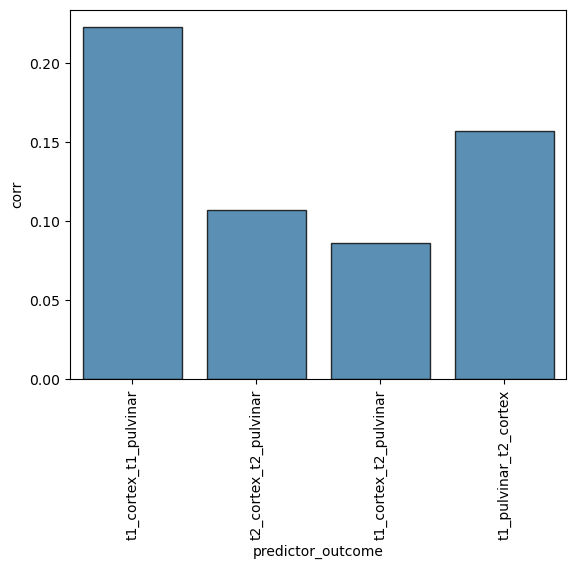

In [11]:
#plot corr as bar graphs
ax = sns.barplot(data = corr_summary, x = 'predictor_outcome', y = 'corr', edgecolor = 'k', alpha = .8)

#orient labels 90 degrees
plt.xticks(rotation=90)

#### Plot network as function of age group

In [14]:
'''Add age group info to df_summary'''

df_network_summary = df_summary.groupby(['sub','ses', 'birth_age', 'scan_age','age', 'age_group','infant_roi', 'infant_network', 'roi_similarity','network_similarity'])['corr'].mean().reset_index()

#extract only subs where roi similarity is same
df_network_summary = df_network_summary[df_network_summary['roi_similarity'] == 'same']


#normalize correlations by noise ceiling

#load infant noise ceilings
infant_noise_network = infant_noise.groupby(['sub','ses', 'birth_age', 'scan_age','roi', 'network'])['fc'].mean().reset_index()
#rename network column to infant_network
infant_noise_network = infant_noise_network.rename(columns = {'roi': 'infant_roi', 'network':'infant_network', 'fc':'noise_ceiling'})

#add fc from infant noise ceiling to df_network_summary
df_network_summary = pd.merge(df_network_summary, infant_noise_network, on = ['sub','ses', 'birth_age', 'scan_age', 'infant_roi', 'infant_network'], how = 'left')

#normalize correlations by noise ceiling
df_network_summary['corr_norm'] = df_network_summary['corr']/df_network_summary['noise_ceiling']


#set network order as categorical and level order
df_network_summary['infant_network'] = pd.Categorical(df_network_summary['infant_network'], categories=network_order, ordered=True)
#set  age group as categorical
df_network_summary['age_group'] = pd.Categorical(df_network_summary['age_group'], categories=age_groups, ordered=True)


network_colors = ['#fd0000','#be00fd', '#1105d8','#00fd00']
network_order= ['Occipital','Ventral','Lateral','Dorsal']

#set network order as categorical and level order
df_network_summary['infant_network'] = pd.Categorical(df_network_summary['infant_network'], categories=network_order, ordered=True)

#set age group as categorical
df_network_summary['age_group'] = pd.Categorical(df_network_summary['age_group'], categories=age_groups, ordered=True)




<Axes: xlabel='age_group', ylabel='corr'>

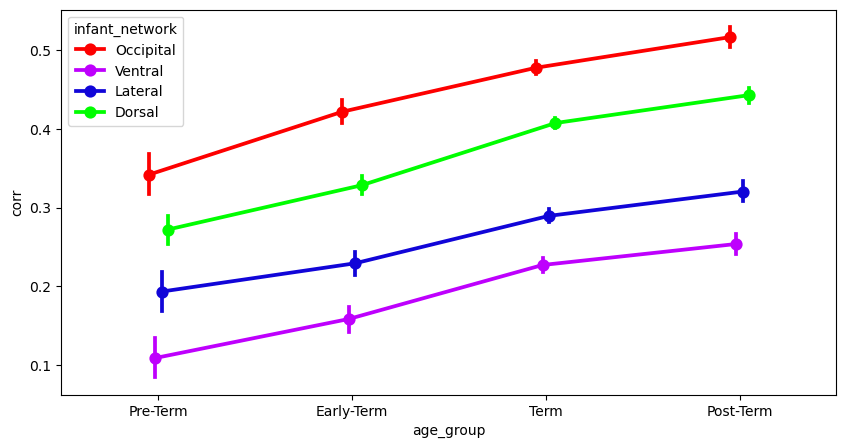

In [16]:
#Make a line plot with age on x axis and corr on y axis, split by infant_network
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.pointplot(data = df_network_summary, x = 'age_group', y = 'corr', hue = 'infant_network', errorbar=('ci', 95), palette = network_colors, ax = ax, dodge=True)


### Evenly samply data at different ages

In [35]:
#compute bins on the basis of scan_age for df_summary
df_summary['age_bins'] = np.nan

bins = 10
df_summary['age_bins'] = pd.cut(df_summary['scan_age'], bins, labels = False)
print(df_summary.groupby('age_bins')['sub'].nunique())

df_network_summary = df_summary.groupby(['sub','ses', 'birth_age', 'scan_age','age', 'age_group', 'infant_network', 'roi_similarity','network_similarity'])['corr'].mean().reset_index()

#extract only subs where roi similarity is same
df_network_summary = df_network_summary[df_network_summary['roi_similarity'] == 'same']

#save df_network_summary
df_network_summary.to_csv(f'{git_dir}/results/infant_adult_{atlas}_equally_space_ages.csv', index = False)



age_bins
0      5
1      8
2     16
3     33
4     53
5     40
6    108
7    200
8    158
9     70
Name: sub, dtype: int64


In [36]:
sub_to_sample = df_summary.groupby(['sub','ses','age_bins']).mean(numeric_only=True).reset_index()

#sample 5 subs from each age bin
sub_sample = sub_to_sample.groupby('age_bins').apply(lambda x: x.sample(5, random_state = 0))

#extract only subs in sub_sample
df_network_summary = df_network_summary[df_network_summary['sub'].isin(sub_sample['sub'])]


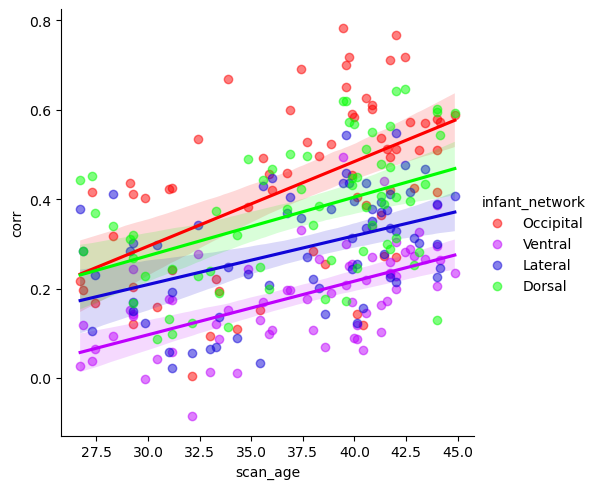

In [38]:
#set network order as categorical and level order
df_network_summary['infant_network'] = pd.Categorical(df_network_summary['infant_network'], categories=network_order, ordered=True)




sns.lmplot(data = df_network_summary, x = 'scan_age', y = 'corr',  hue = 'infant_network',  ci = 95, scatter_kws = {'alpha':.5},  palette = network_colors)

### Extract subs that have more than one session

In [20]:
#extract subs that appear twice in subs2analyze
subs_2ses = subs2analyze[subs2analyze['participant_id'].duplicated(keep=False) == True]


df_network_summary = df_summary.groupby(['sub','ses', 'birth_age', 'scan_age','age', 'age_group', 'infant_network', 'roi_similarity','network_similarity'])['corr'].mean().reset_index()
#keep only subs that appear in subs_2ses
df_network_summary = df_network_summary[df_network_summary['sub'].isin(subs_2ses['participant_id'])]

#extract only subs where roi similarity is same
df_network_summary = df_network_summary[df_network_summary['roi_similarity'] == 'same']

#create session_num col
df_network_summary['session_num'] = np.nan

#create new column that uses scan_age to determine whether sub is ses1 or ses2
for sub in df_network_summary['sub'].unique():
    sub_df = df_network_summary[df_network_summary['sub'] == sub]
    ses1_age = sub_df['scan_age'].min()
    ses2_age = sub_df['scan_age'].max()

    #set session_num to 1 if scan_age is equal to ses1_age
    df_network_summary.loc[(df_network_summary['sub'] == sub) & (df_network_summary['scan_age'] == ses1_age), 'session_num'] = 1
    #set session_num to 2 if scan_age is equal to ses2_age
    df_network_summary.loc[(df_network_summary['sub'] == sub) & (df_network_summary['scan_age'] == ses2_age), 'session_num'] = 2

#extract session 1 and session 2 data seperately
df_diff = df_network_summary[df_network_summary['session_num'] == 1]
df_session2 = df_network_summary[df_network_summary['session_num'] == 2]

#add session2 corr as new column to session1 using merge
df_diff = pd.merge(df_diff, df_session2[['sub','infant_network','corr','scan_age']], on = ['sub','infant_network'], how = 'left')

#create new column that subtracts session2 corr from session1 corr
df_diff['diff'] = df_diff['corr_y'] - df_diff['corr_x']

#create scan_age diff
df_diff['age_diff'] = df_diff['scan_age_y'] - df_diff['scan_age_x']



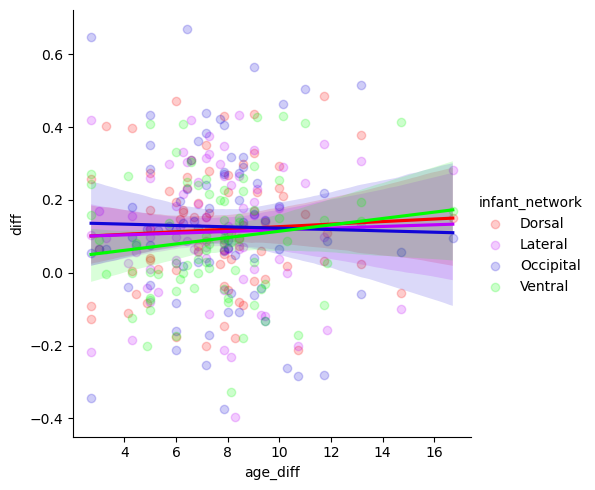

In [22]:
#create lmplot with scan_age diff on x axis and corr diff on y axis
sns.lmplot(data = df_diff, x = 'age_diff', y = 'diff',  hue = 'infant_network',  ci = 95, scatter_kws = {'alpha':.2},  palette = network_colors)

#

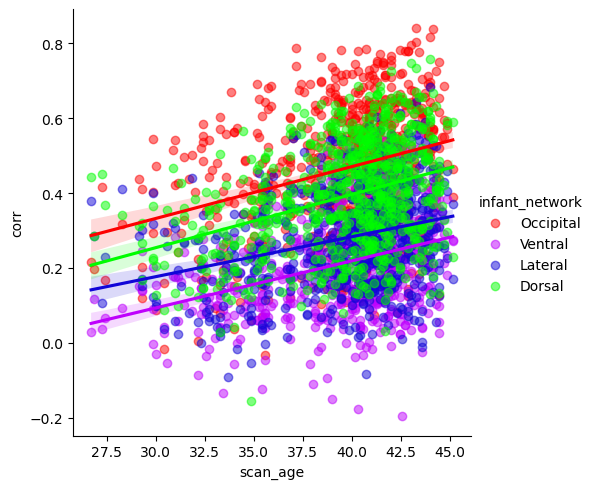

In [32]:
# create lmplots plotting correlation as a function of scan_age
df_network_summary = df_summary.groupby(['sub','ses', 'birth_age', 'scan_age','age','infant_network', 'roi_similarity','network_similarity'])['corr'].mean().reset_index()
df_same_only = df_network_summary[df_network_summary['roi_similarity'] == 'same']

#save
df_same_only.to_csv(f'{git_dir}/results/infant_adult_{atlas}_similarity_same.csv', index = False)

#set network order as categorical and level order
df_same_only['infant_network'] = pd.Categorical(df_same_only['infant_network'], categories=network_order, ordered=True)




sns.lmplot(data = df_same_only, x = 'scan_age', y = 'corr',  hue = 'infant_network',  ci = 95, scatter_kws = {'alpha':.5},  palette = network_colors)

In [27]:
#regress out age and save residuals in new column
df_same_only['arealization_age_resid'] = np.nan
df_same_only['arealization_gestation_resid'] = np.nan
for network in networks:
    #regress out age
    curr_data = df_same_only[df_same_only['infant_network'] == network]
    X = stats.zscore(curr_data['age'])
    y = stats.zscore(curr_data['corr'])

    #fit linear model
    model = sm.OLS(y,X).fit()
    df_same_only.loc[df_same_only['infant_network'] == network, 'arealization_age_resid'] = model.resid
    
    #regress out scan_age
    X = stats.zscore(curr_data['scan_age'])
    y = stats.zscore(curr_data['corr'])

    #fit linear model
    model = sm.OLS(y,X).fit()
    df_same_only.loc[df_same_only['infant_network'] == network, 'arealization_gestation_resid'] = model.resid

   
    

Text(39.10439763374485, 0.5, 'Arealization Index')

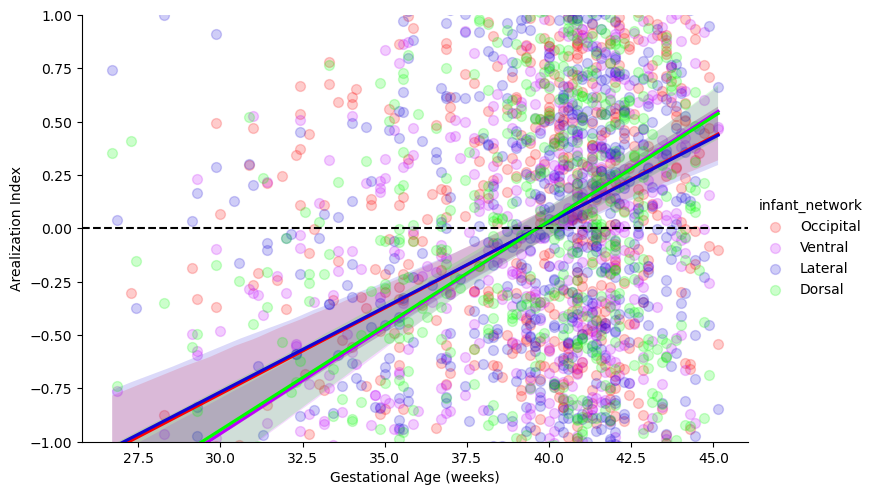

In [30]:
#make lmplots of residuals as a function of gestational age (scan_age), controlling for age since birth
sns.lmplot(data = df_same_only, x = 'scan_age', y = 'arealization_age_resid', hue = 'infant_network', palette = network_colors, scatter_kws = {'s': 50,  'alpha':.2}, height = 5, aspect = 1.5)
#dotted line at 0
plt.axhline(y=0, color = 'black', linestyle = '--')

#set ylim
plt.ylim(-1,1)

# set x label to gestational age
plt.xlabel('Gestational Age (weeks)')
plt.ylabel('Arealization Index')

Text(39.10439763374485, 0.5, 'Arealization Index')

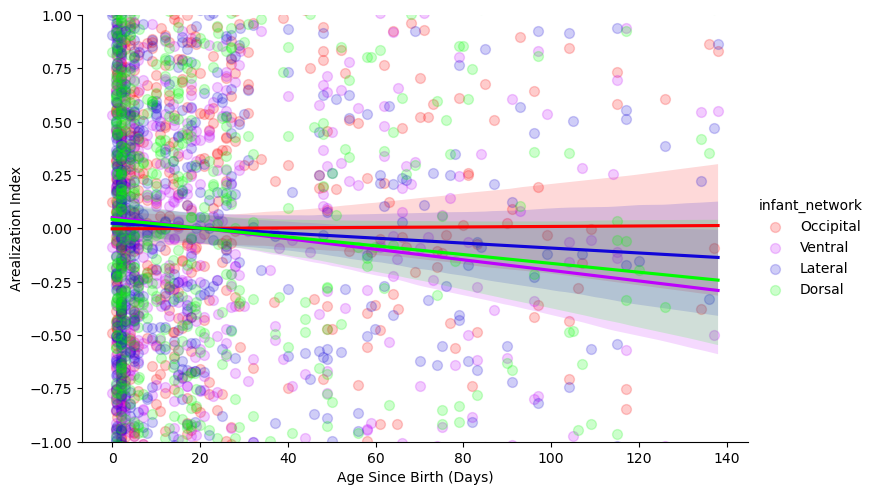

In [31]:
#plot residuals as a function of age since birth controlling for gestational age(scan_age)
sns.lmplot(data = df_same_only, x = 'age', y = 'arealization_gestation_resid', hue = 'infant_network', palette = network_colors, scatter_kws = {'s': 50,  'alpha':.2}, height = 5, aspect = 1.5)
plt.ylim(-1,1)

#set X label to age since birth
plt.xlabel('Age Since Birth (Days)')
plt.ylabel('Arealization Index')

## Measure Hierarchy

In [17]:
network_rois = [['V1v', 'V2v','V3v', 'hV4','VO1','VO2','PHC1','PHC2'], ['V1d', 'V2d','V3d', 'V3a','V3b','IPS0','IPS1','IPS2','IPS3','IPS4','IPS5','SPL1'], ['V1d', 'V2d','V3d', 'LO1','LO2','hMT', 'MST']]
networks = ['Ventral', 'Dorsal', 'Lateral']

hierarchy_num = pd.Series([1,1,2,2,3,3,4,5,6,7,8,4,5,6,7,4,5,6,7,8,9,10,11,12])

color_maps =[['#25044d', '#2a00ba', '#0833cd','#0e6896', '#0fa35c', '#55ee1a', '#efeb00', '#ff2200'], 
['#25044d', '#3000a6', '#0826d8', '#0826d8', '#118479', '#13c53f', '#8efa07', '#f8dd00', '#ff2200'],
['#25044d', '#1018db', '#0f6499', '#0dae53', '#9dfb03', '#ff2200']]

roi_labels['hierarchy_num'] = hierarchy_num

summary_type = '_fc'

#load seed correlations and summarize
df_summary = pd.read_csv(f'{git_dir}/results/infant_adult_roi_similarity{summary_type}.csv')

#replace TO1 with hMT
adult_noise_ceilings = pd.read_csv(f'{params.results_dir}/noise_ceilings/adult_{atlas}_fc_loo_noise_ceilings.csv')
#add sub column as index

df_roi_summary = df_summary.groupby(['sub','infant_roi','infant_network','roi_similarity'])['corr'].mean().reset_index()

#extract only same
df_roi_summary = df_roi_summary[df_roi_summary['roi_similarity'] == 'same']

df_roi_summary= df_roi_summary.reset_index()


df_noise = pd.read_csv(f'{params.results_dir}/noise_ceilings/adult_{atlas}_fc_loo_noise_ceilings.csv')
#replace TO1 with hMT
#df_noise['roi'] = df_noise['roi'].replace('TO1', 'hMT')
df_noise_roi = df_noise.groupby(['roi1','roi_similarity'])['corr'].mean().reset_index()
df_noise_roi = df_noise_roi[df_noise_roi['roi_similarity'] == 'same']

#normalize each infant roi by the noise ceiling
df_roi_summary = df_roi_summary.merge(df_noise_roi, left_on='infant_roi', right_on='roi1')
df_roi_summary['corr_norm'] = df_roi_summary['corr_x']/df_roi_summary['corr_y']


#add column that has the hiearchy number for each infant_roi
for roi, num in zip(roi_labels['label'], roi_labels['hierarchy_num']):
    df_roi_summary.loc[df_roi_summary['infant_roi'] == roi, 'hierarchy_num'] = num

Ventral
['V1v', 'V2v', 'V3v', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2']


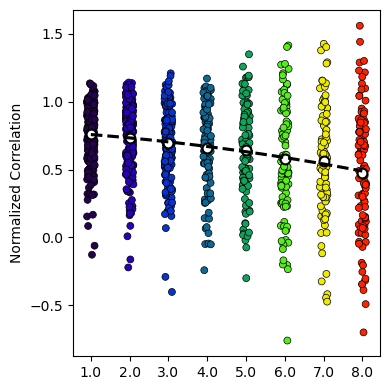

Dorsal
['V1d', 'V2d', 'V3d', 'V3a', 'V3b', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5', 'SPL1']


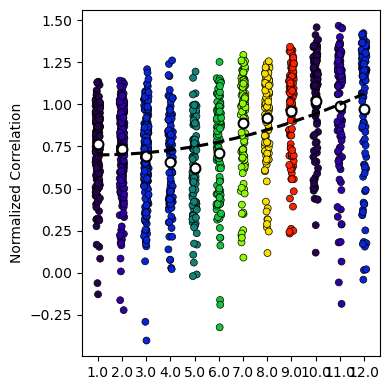

Lateral
['V1d', 'V2d', 'V3d', 'LO1', 'LO2', 'hMT', 'MST']


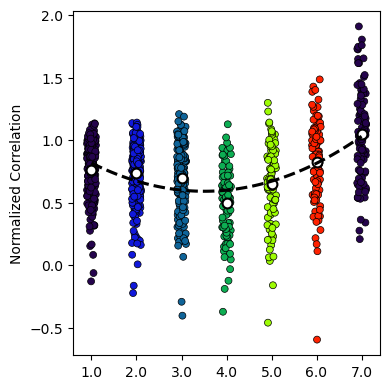

In [23]:
#add line for noise ceiling

for network, rois in zip(networks, network_rois):
    print(network)
    print(rois)
    curr_data = df_roi_summary[(df_roi_summary['infant_network'] == 'Occipital') | (df_roi_summary['infant_network'] == network)]

    #set curr_data infant_network to categorical with order network  roi
    curr_data['infant_roi'] = pd.Categorical(curr_data['infant_roi'], categories = rois, ordered = True)

    #set current color map
    curr_color_map = color_maps[networks.index(network)]
  



    #compute mean and sem for each roi
    curr_data_mean = curr_data.groupby('hierarchy_num')['corr_norm'].mean().reset_index()
    curr_data_mean['hierarchy_num'] = curr_data_mean['hierarchy_num'] -1
    


    
    #sns.scatterplot(data=curr_data, x='hierarchy_num', y='corr')
    #plot individual data
    sns.stripplot(data = curr_data, x = 'hierarchy_num', y = 'corr_norm', hue = 'hierarchy_num', palette= curr_color_map, linewidth = .5, s = 5, edgecolor = 'k',jitter=.1,zorder = 0)
    #plt.plot(x,y, color = 'k', linestyle = '--',)
    
    #plot means for each category as individual points
    sns.scatterplot(data = curr_data_mean, x = 'hierarchy_num', y = 'corr_norm', color = 'white',edgecolor='k',linewidth =1.5,s = 50, zorder = 1)
    #plot as violin plot
    #sns.violinplot(data = curr_data, x = 'hierarchy_num', y = 'corr_norm', hue = 'hierarchy_num', palette = curr_color_map, alpha = .5, inner = 'quart')

    sns.regplot(data = curr_data_mean, x = 'hierarchy_num', y = 'corr_norm', scatter = False, color = 'k', ci = None, line_kws = {'linestyle':'--'}, order=2)

    #sns.scatterplot(curr_data_mean['hierarchy_num'], curr_data_mean['corr_norm'], color = 'white',edgecolors='k', s = 50, zorder = 1)

    #replace x-axis with roi names
    #plt.xticks(np.arange(len(rois)), rois, rotation = 90)

    
    plt.ylabel('Normalized Correlation')

    #remove x-axis label
    plt.xlabel('')
    
    
    plt.legend([],[], frameon=False)

    #set plot size
    plt.gcf().set_size_inches(4,4)
    plt.tight_layout()

    #plt.savefig(f'{git_dir}/figures/{network}_roi_hierarchy_correlations.png', dpi = 300)
    plt.pause(.001)

## Adult data

In [63]:
#replace TO1 with hMT
adult_df = pd.read_csv(f'{params.results_dir}/noise_ceilings/adult_{atlas}_fc_loo_noise_ceilings.csv')
#add sub column as index

df_network_summary = adult_df.groupby(['sub', 'hemi1','network1', 'roi_similarity', 'network_similarity'])['corr'].mean().reset_index()

df_roi_summary = adult_df.groupby(['roi1', 'roi2', 'network2', 'roi_similarity'])['corr'].mean().reset_index()


/tmp/ipykernel_3552255/3313473090.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(curr_data.groupby(['network1','network_similarity'])['corr'].mean())
/tmp/ipykernel_3552255/3313473090.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(curr_data.groupby(['network1','network_similarity'])['corr'].mean())
/tmp/ipykernel_3552255/3313473090.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(curr_da

network1   network_similarity
Occipital  same                  0.760139
           different             0.112331
Name: corr, dtype: float64
network1  network_similarity
Ventral   same                  0.529126
          different             0.090119
Name: corr, dtype: float64
network1  network_similarity
Lateral   same                  0.551008
          different             0.200876
Name: corr, dtype: float64
network1  network_similarity
Dorsal    same                  0.626545
          different             0.041290
Name: corr, dtype: float64


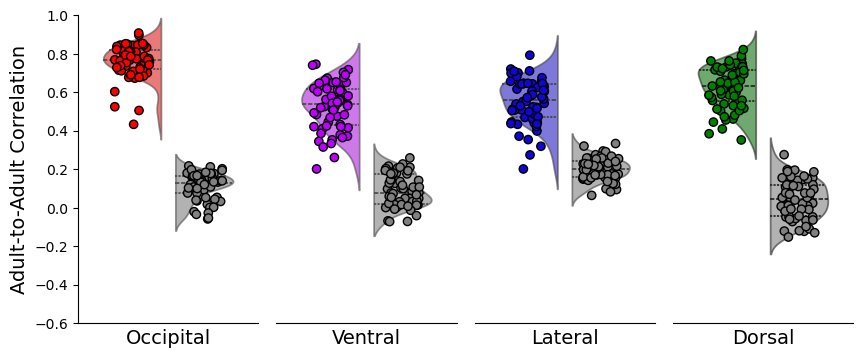

In [64]:
'''plot sub data at network level'''


#remove same region comparisons from df_summary_grouped and df_noise_grouped


#set network order
network_order = ['Occipital', 'Ventral', 'Lateral', 'Dorsal']
comp_order = ['same','different']
#comp_order = ['Same\nRegion','Same\nNetwork','Different\nNetwork']


#set network order as categorical and level order
df_network_summary['network_similarity'] = pd.Categorical(df_network_summary['network_similarity'], categories=comp_order, ordered=True)
#df_summary_grouped['infant_network'] = pd.Categorical(df_summary_grouped['infant_network'], categories=network_order, ordered=True)


#create list of 12 gray colors
network_colors = [['#fd0000','gray'], ['#be00fd', 'gray'], ['#1105d8', 'gray'], ['green', 'gray']]

#loop through networks and create subplot for each
#set subplot size
fig,ax = plt.subplots(1,4,figsize=(10,4),sharey=False)
for i in range(0,len(network_order)):
    #print(network_order[i])
    curr_data = df_network_summary[(df_network_summary['network1']==network_order[i]) & (df_network_summary['roi_similarity'] == 'same') | 
                                   (df_network_summary['network1']==network_order[i]) & (df_network_summary['network_similarity'] == 'different')]
    
    print(curr_data.groupby(['network1','network_similarity'])['corr'].mean())
    
    #add horizontal line at noise ceiling
    #ax[i].axhline(y=df_noise_network.loc[df_noise_network['network1']==network_order[i],'corr'].values[0], color = 'k', linestyle = '--')
    #add opaque rectangle behind noise ceiling with width of the standard deviation
    #ax[i].axhspan(df_noise_network.loc[df_noise_network['network1']==network_order[i],'corr'].values[0]-df_noise_network.loc[df_noise_network['network1']==network_order[i],'std'].values[0],
    #              df_noise_network.loc[df_noise_network['network1']==network_order[i],'corr'].values[0]+df_noise_network.loc[df_noise_network['network1']==network_order[i],'std'].values[0],
    #              alpha=0.2, color='k')
        
    #add horizontal line at mean
    #ax[i].axhline(y=curr_data[curr_data['roi_similarity']=='same']['corr'].mean(), color = 'r', linestyle = '--')
    
    #plot summary_df
    sns.violinplot(data=curr_data, x= 'network1', y= 'corr', hue='network_similarity',
                   split = True,gap = .2, alpha = .6, inner = 'quart', palette = network_colors[i], ax = ax[i])

    #set alpha for all artists
    #for artist in ax[i].artists:
    #    artist.set_alpha(.5)

    sns.stripplot(data = curr_data,  x= 'network1', y= 'corr', hue = 'network_similarity', 
                  dodge=True,edgecolor = 'black', alpha = 1, linewidth=1,jitter = .2, size = 6,
                    palette = network_colors[i], ax = ax[i])




    
    #increase font size of x and y ticks
    #plt.xticks(fontsize = 10)
    #plt.yticks(fontsize = 10)

    #set y limits
    ax[i].set_ylim([-.6,1])

    #add y label
    if i == 0:

        ax[i].set_ylabel('Adult-to-Adult Correlation', fontsize = 14)
        #make axes black
        ax[i].spines['left'].set_color('k')
        



    else:
        
        #remove y label
        ax[i].set_ylabel('')
        #remove y ticks
        ax[i].set_yticks([])
        #remove y tick labels
        ax[i].set_yticklabels([])
        #remove y axis line
        ax[i].spines['left'].set_visible(False)

    #remove x ticks and labels
    ax[i].set_xticks([])
    ax[i].set_xticklabels([])
    
    #add network as xlabel for each subplort
    ax[i].set_xlabel(network_order[i], fontsize = 14)
    #add x label
    #plt.xlabel('Network', fontsize = 20)

    #make axes black
    ax[i].spines['bottom'].set_color('k')
    

    #remove top and right axes
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

    #remove legend
    ax[i].get_legend().remove()

    #print(curr_data.groupby(['infant_network','comparison'])['corr'].mean().reset_index())

plt.subplots_adjust(wspace=.1, hspace=0)

#save 
#plt.savefig(f'{git_dir}/figures/infant_adult_seed_correlation.png', bbox_inches='tight', dpi=300)

/home/vayzenb/anaconda3/envs/ml/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 0, '')

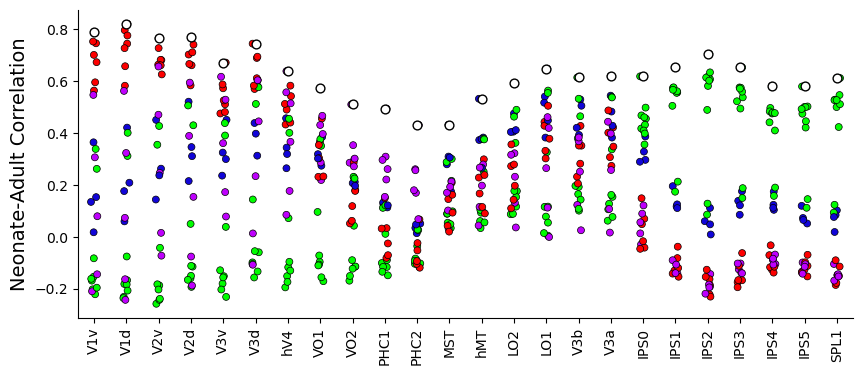

In [65]:
'''Plot data at roi level'''
network_colors = ['#fd0000','#be00fd', '#1105d8','#00fd00']
network_order= ['Occipital','Ventral','Lateral','Dorsal']

#set network order as categorical and level order
df_roi_summary['roi1'] = pd.Categorical(df_roi_summary['roi1'], categories=roi_labels['label'], ordered=True)
df_roi_summary['network2'] = pd.Categorical(df_roi_summary['network2'], categories=network_order, ordered=True)

df_roi_same = df_roi_summary[(df_roi_summary['roi1']==df_roi_summary['roi2']) & (df_roi_summary['roi_similarity'] == 'same')]



sns.scatterplot(data = df_roi_same, x = 'roi1', y = 'corr', color = 'white', linewidth = 1, s = 40, edgecolor = 'k', legend = False,zorder = 10)
sns.stripplot(data = df_roi_summary, x = 'roi1', y = 'corr', hue = 'network2', palette = network_colors, linewidth = .5, s = 5, edgecolor = 'k',jitter=.1,zorder = 0)


#create scatter plot of noise ceiling
#sns.scatterplot(data = df_noise_roi, x = 'roi1', y = 'corr', color = 'black', linewidth = 1, s = 100, marker="_", edgecolor = 'k', legend = False, zorder =15)

#remove legend
plt.legend([],[], frameon=False)

#change plot size
plt.gcf().set_size_inches(10,4)

#angle x axis labels
plt.xticks(rotation=90)

#remove top and right spines
sns.despine()

#add y axis label
plt.ylabel('Neonate-Adult Correlation', fontsize = 14)

#remove X axis label
plt.xlabel('')

#save
#plt.savefig(f'{git_dir}/figures/infant_adult_seed_correlation_roi.png', bbox_inches='tight', dpi=300)

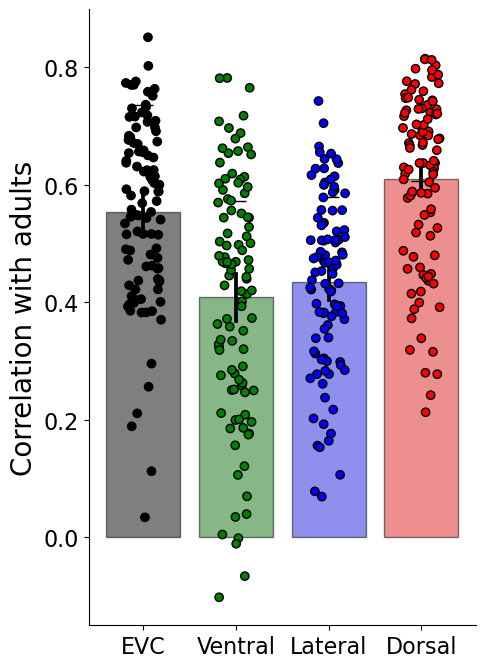

In [24]:
'''
Plot infant-adult correlations with adult noise ceilings
'''
summary_type = 'fc'
#load adult noise ceiling data
adult_noise_ceilings = pd.read_csv(f'{params.results_dir}/noise_ceilings/adult_{atlas}_{summary_type}_network_noise_ceilings.csv')

#load infant summary data

summary_df = pd.read_csv(f'{params.results_dir}/infant_adult_network_{summary_type}.csv')

#drop overall
summary_df = summary_df.drop(columns = ['overall'])

#plot
plot_network_corr(summary_df, noise_ceiling_df = adult_noise_ceilings)

### Age correlations

birth_age
Occipital: 0.28279862094440694 SignificanceResult(statistic=0.38105297611511874, pvalue=3.593702752913796e-22)
Ventral: 0.24285344886980054 SignificanceResult(statistic=0.2598168155751885, pvalue=3.7083414479688457e-09)
Lateral: 0.3949309604185954 SignificanceResult(statistic=0.43201012222509844, pvalue=1.2843161129469073e-19)
Dorsal: 0.37521416938842433 SignificanceResult(statistic=0.44979356606542353, pvalue=4.92922191476833e-46)
scan_age
Occipital: -0.13508691323934188 SignificanceResult(statistic=-0.14512712409447853, pvalue=0.00036197571435498706)
Ventral: -0.19709446498925096 SignificanceResult(statistic=-0.1698967795931897, pvalue=0.0001349279271623979)
Lateral: -0.24991590810758066 SignificanceResult(statistic=-0.1386962139694303, pvalue=0.00545794261876568)
Dorsal: -0.1717823259614787 SignificanceResult(statistic=-0.13966596487061353, pvalue=2.6133525484126236e-05)


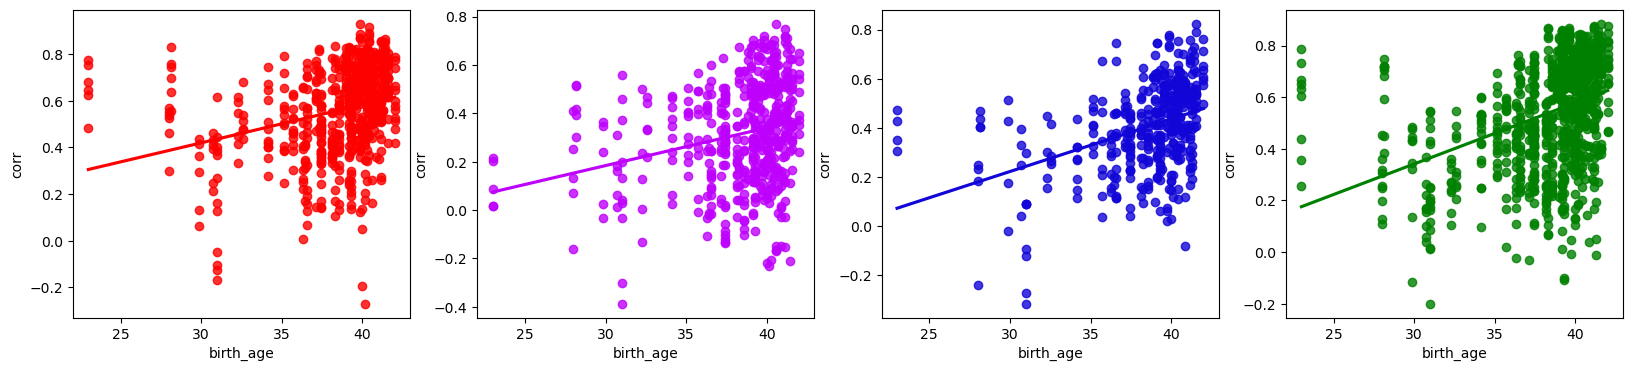

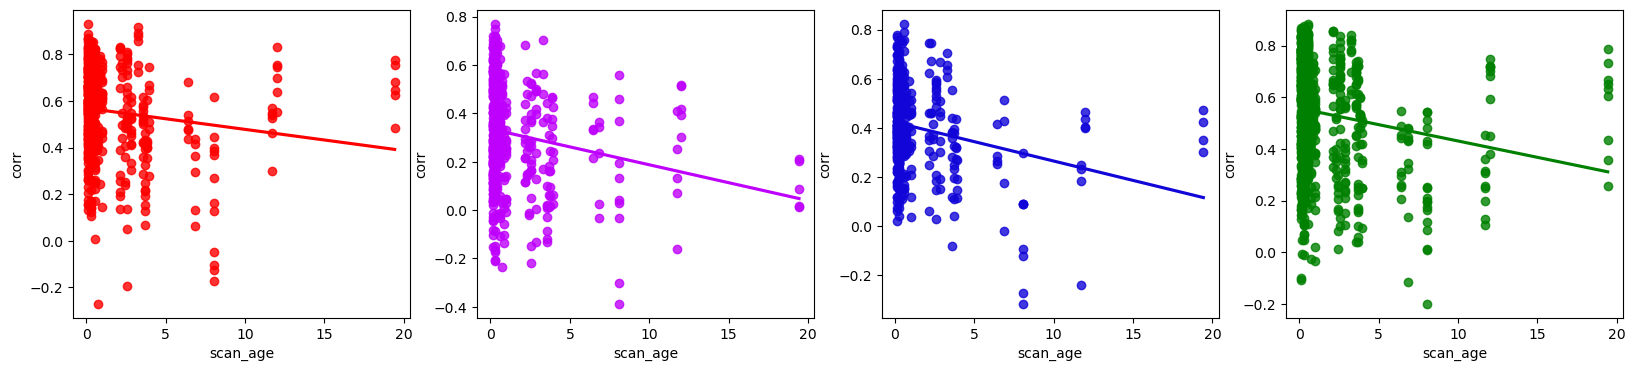

In [46]:
networks = ['Occipital', 'Ventral', 'Lateral', 'Dorsal']
df_summary_same = df_summary[df_summary['roi_similarity'] == 'same']
df_summary_same = df_summary_same.groupby(['sub','birth_age','scan_age','infant_network','infant_roi','roi_similarity'])['corr'].mean().reset_index()

age_types = ['birth_age','scan_age']

df_summary_same['scan_age'] = df_summary_same['scan_age'] - df_summary_same['birth_age']

for age_type in age_types:
    print(age_type)
    #append age to summary_df
    


    #create subplot for each network
    fig, ax = plt.subplots(1,len(networks), figsize = (20,4))
    for network in networks:
        curr_df = df_summary_same[df_summary_same['infant_network'] == network]
        #print correlation
        print(f'{network}: {np.corrcoef(curr_df[age_type], curr_df['corr'])[0,1]}', stats.spearmanr(curr_df[age_type], curr_df['corr']))
        #plot scatterplot with network color and trendline
        sns.regplot(data = curr_df, x = age_type, y = 'corr', color = network_colors[networks.index(network)], ax = ax[networks.index(network)], ci = None)

        

    #markersize = 15, markeredgecolor = 'k'